In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

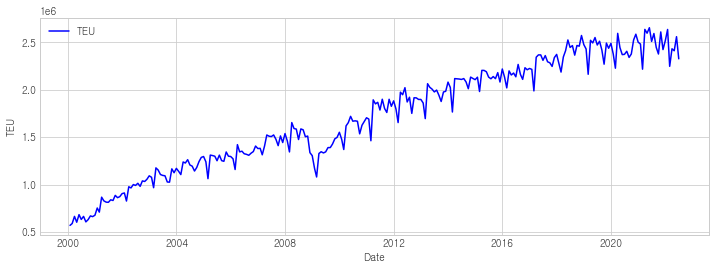

In [6]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='TEU')
plt.legend()

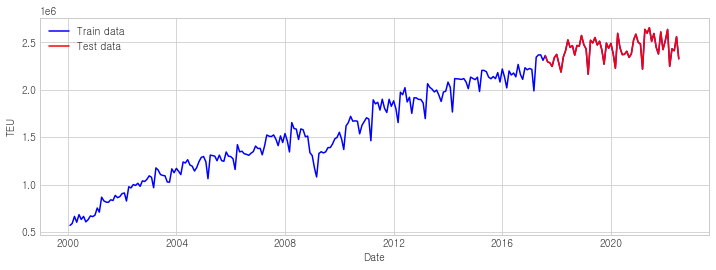

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
seasonal = pd.read_csv('계절성예측.csv')

In [9]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -80
train = raw_df[0:split] 
test = raw_df[split:] 

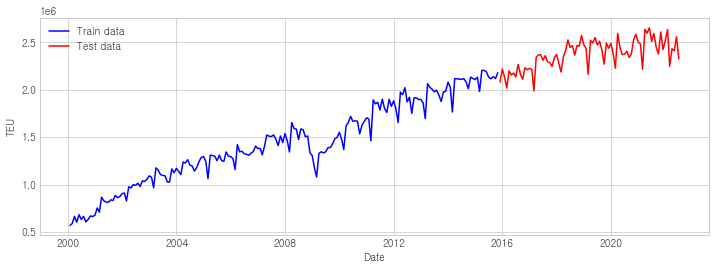

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [17]:
len(train),len(test)

(190, 80)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 20 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 60   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((111, 20, 10), (111, 60, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((1, 20, 10), (1, 60, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
n_hidden = 64
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(Y_train.shape[1], Y_train.shape[2]))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh',return_state = True, return_sequences=True)(input_train)

encoder_stack_h = MCDropout(0.8)(encoder_stack_h)
encoder_last_h = MCDropout(0.8)(encoder_last_h)
encoder_last_c = MCDropout(0.8)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation = 'tanh',
                       return_state =False , 
                       return_sequences = True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

decoder_stack_h = MCDropout(0.8)(decoder_stack_h)

attention = dot([decoder_stack_h, encoder_stack_h], axes = [2,2])
attention = Activation('softmax')(attention)

context = dot([attention, encoder_stack_h], axes = [2,1])

decoder_combined_context = concatenate([context, decoder_stack_h])

out = TimeDistributed(Dense(8,activation='relu'))(decoder_combined_context)
out = TimeDistributed(Dense(1))(out)

model = Model(inputs=input_train, outputs = out)
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
11/11 [==============================] - 12s 684ms/step - loss: 0.3131 - mae: 0.4896 - val_loss: 0.1102 - val_mae: 0.2833
Epoch 2/200
11/11 [==============================] - 1s 80ms/step - loss: 0.0772 - mae: 0.2172 - val_loss: 0.2122 - val_mae: 0.4306
Epoch 3/200
11/11 [==============================] - 1s 55ms/step - loss: 0.0490 - mae: 0.1758 - val_loss: 0.1409 - val_mae: 0.3453
Epoch 4/200
11/11 [==============================] - 1s 49ms/step - loss: 0.0387 - mae: 0.1548 - val_loss: 0.0862 - val_mae: 0.2545
Epoch 5/200
11/11 [==============================] - 1s 56ms/step - loss: 0.0303 - mae: 0.1367 - val_loss: 0.0873 - val_mae: 0.2596
Epoch 6/200
11/11 [==============================] - 1s 49ms/step - loss: 0.0283 - mae: 0.1321 - val_loss: 0.0697 - val_mae: 0.2238
Epoch 7/200
11/11 [==============================] - 1s 50ms/step - loss: 0.0248 - mae: 0.1248 - val_loss: 0.0464 - val_mae: 0.1838
Epoch 8/200
11/11 [==============================] - 1s 49ms/step - loss: 

In [28]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

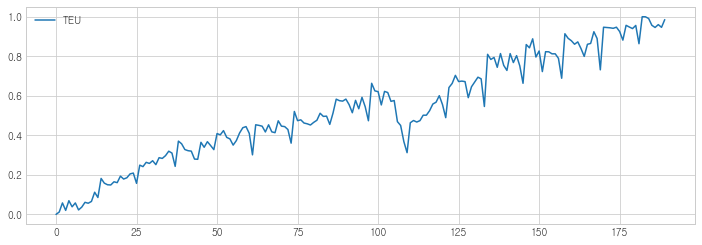

In [29]:
label_train.plot()

<AxesSubplot:>

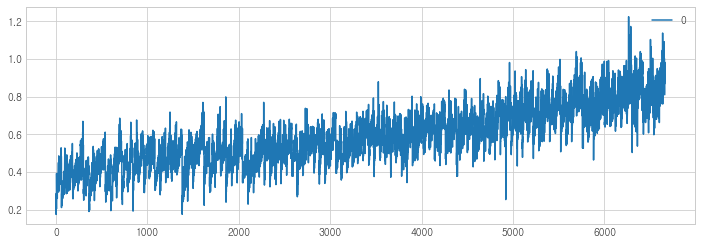

In [30]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### Test 데이터 Sequence 반복 이동 예측 ( 총합 5번 시행)

In [31]:
X_test_1 = np.array(feature_test.head(20)).reshape((1,20, 10)) 

In [32]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [33]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

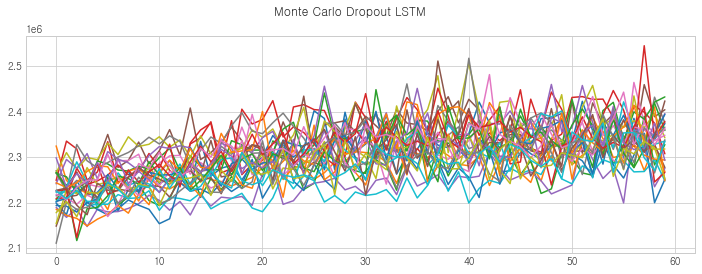

In [34]:
rcParams['figure.figsize'] = 12, 4
plt.suptitle('Monte Carlo Dropout LSTM')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [35]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [36]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [37]:
np.mean(df.std()/df.mean())

0.02252689003944397

In [38]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().mean())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 138004.7087869104
MAPE: 5.460132888163029


In [39]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().median())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 139493.04545840094
MAPE: 5.511972030293892


In [40]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2199283.5,2324946.75,2206666.5,2248900.0,2189918.25,2270455.75,2200676.25,2215254.5,2265881.0,2222853.0,2194052.5,2185729.5,2264393.75,2209476.0,2241608.5,2148323.25,2218170.75,2265925.75,2153976.0,2201269.5,2202971.5,2243834.75,2266813.0,2225538.75,2299060.75,2227315.0,2226286.25,2110740.5,2178089.5,2226106.5


In [41]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 167394.71210229557
Mean MAPE: 5.861002829591099


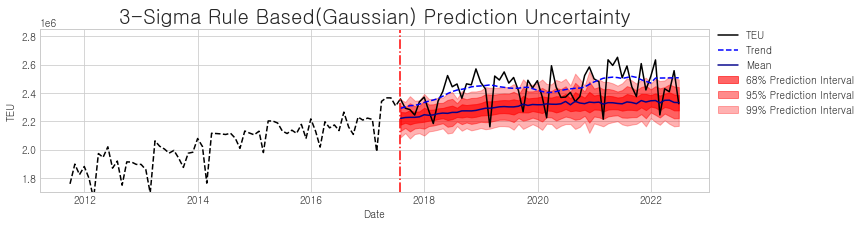

In [42]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='darkblue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().mean())/ test_data.reset_index()['TEU'])*100) )

In [43]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.31666666666666665

In [44]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.0

In [45]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 96266.54
Quantile 70% Interval Sharpness 93810.55249999999


Median RMSE: 168185.83972146426
Median MAPE: 5.879797539667984


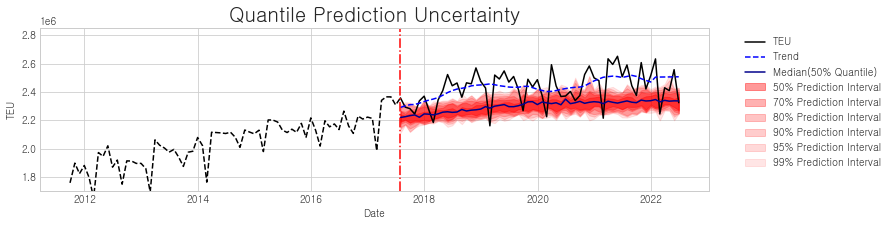

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.reset_index()['TEU'])*100) )

In [47]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.2833333333333333

In [48]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.0

RMSE: 164442.19019428923
MAPE: 5.703859721359153


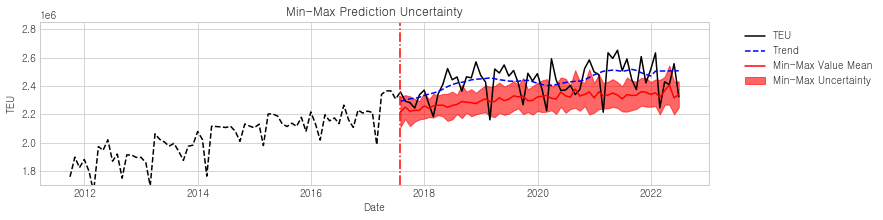

In [49]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='blue',label='Trend',linestyle='dashed')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='red',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='red',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.plot()
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [50]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.35

In [51]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 192533.1
Quantile 95% Interval Sharpness 171436.61468750003
Min Max Interval Sharpness 196738.58


In [52]:
import CRPS.CRPS as pscore

In [53]:
crps = []

for i in range(0,60):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(60).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

113071.30888888889
51710.15222222222
33077.017499999994
10262.200277777778
83962.33277777777
97093.51222222221
17025.328055555554
40929.972222222226
68783.03
131797.67861111113
239984.70166666666
154209.78305555554
183371.0011111111
67082.3361111111
167831.5086111111
159537.78666666668
267503.0175
164764.93527777778
107847.3575
104905.5338888889
197621.74972222222
164407.67527777777
218982.66444444444
142060.58944444446
178739.17583333334
88078.61611111111
29940.79194444445
150322.0236111111
91110.29555555555
141552.96222222224
31068.94861111111
73779.20638888888
245136.49333333335
91121.69888888887
34104.54083333333
16359.888055555553
62023.092222222214
16004.949166666669
26231.91527777777
174887.20111111112
208818.08444444445
140113.55944444443
115458.2675
77180.66333333333
275167.14666666667
238151.90944444443
302424.83944444446
156931.64111111112
223361.15277777778
82880.04055555555
35663.34111111111
234647.06222222222
56562.28472222222
147576.95805555556
258042.48861111113
59518.7

In [54]:
a = np.array([113071.30888888889,
51710.15222222222,
33077.017499999994,
10262.200277777778,
83962.33277777777,
97093.51222222221,
17025.328055555554,
40929.972222222226,
68783.03,
131797.67861111113,
239984.70166666666,
154209.78305555554,
183371.0011111111,
67082.3361111111,
167831.5086111111,
159537.78666666668,
267503.0175,
164764.93527777778,
107847.3575,
104905.5338888889,
197621.74972222222,
164407.67527777777,
218982.66444444444,
142060.58944444446,
178739.17583333334,
88078.61611111111,
29940.79194444445,
150322.0236111111,
91110.29555555555,
141552.96222222224,
31068.94861111111,
73779.20638888888,
245136.49333333335,
91121.69888888887,
34104.54083333333,
16359.888055555553,
62023.092222222214,
16004.949166666669,
26231.91527777777,
174887.20111111112,
208818.08444444445,
140113.55944444443,
115458.2675,
77180.66333333333,
275167.14666666667,
238151.90944444443,
302424.83944444446,
156931.64111111112,
223361.15277777778,
82880.04055555555,
35663.34111111111,
234647.06222222222,
56562.28472222222,
147576.95805555556,
258042.48861111113,
59518.72305555556,
58465.224722222236,
44324.40694444445,
192865.8811111111,
16052.387777777774])

In [55]:
np.mean(a)

122708.18392129631

In [56]:
2.6e6 - 2.2e6

400000.0

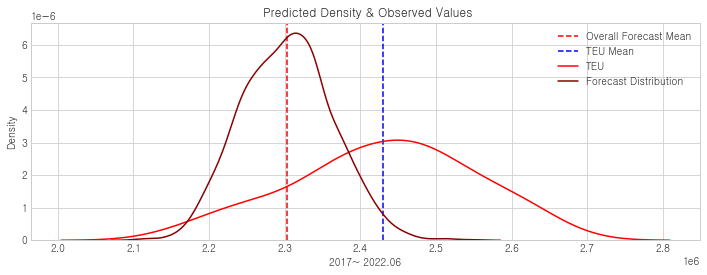

In [57]:
plt.figure(figsize=(12,4))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='red',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.mean(), color='blue',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=False)
sns.distplot(df.transpose(),color='darkred',label='Forecast Distribution',hist=False)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [58]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [59]:
for i in range(0,30):
    print(KL(df[i],test_data.reset_index()['TEU']))

7033459.707273169
8768893.119946241
8788992.809541559
5336827.990288171
11135854.838514518
4843613.65071534
6705865.392925811
7010449.944009847
4442669.179376132
11154056.363681212
9636084.748931933
8870185.0558563
5673548.289183722
4941521.203872479
5366585.567663956
7237733.3703605635
7406881.613837577
4635213.347926592
7532112.145645057
7571313.80205594
7126864.662076804
6058743.627211103
7056454.546815123
6625931.828759878
7032515.948910612
7429763.446120773
6137855.73250009
8822333.69384577
8739008.339437215
8840843.03495479


In [60]:
a = np.array([7033459.707273169,
8768893.119946241,
8788992.809541559,
5336827.990288171,
11135854.838514518,
4843613.65071534,
6705865.392925811,
7010449.944009847,
4442669.179376132,
11154056.363681212,
9636084.748931933,
8870185.0558563,
5673548.289183722,
4941521.203872479,
5366585.567663956,
7237733.3703605635,
7406881.613837577,
4635213.347926592,
7532112.145645057,
7571313.80205594,
7126864.662076804,
6058743.627211103,
7056454.546815123,
6625931.828759878,
7032515.948910612,
7429763.446120773,
6137855.73250009,
8822333.69384577,
8739008.339437215,
8840843.03495479])

In [61]:
np.mean(a)

7265405.9000746105

In [62]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess,df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]

In [63]:
weight

2303020.0

In [68]:
df.to_csv('Attention.csv')

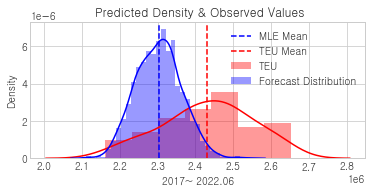

In [64]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [65]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.reset_index()['TEU'].mean(), scale=test_data.reset_index()['TEU'].std() ) )
LL

23952.407363252674

In [66]:
LL = -np.sum( stats.norm.logpdf(test_data.reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

1344.4389872088066